# Logistic regression can fail with sum of squares

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

We read in the [mtcars
dataset](https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/mtcars)
that will be very familiar to users of R:

In [2]:
mtcars = pd.read_csv('mtcars.csv')
mtcars.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


This dataset has one row per make and model of car.  The columns have various measures and other information about each make and model.

The columns we are interested in here are:

* `mpg`: Miles/(US) gallon
* `am`: Transmission (0 = automatic, 1 = manual)

Notice that `am` is already numeric, and so is already a dummy variable.

In [3]:
mpg = mtcars['mpg']
am_dummy = mtcars['am']

We will try to predict whether the car has an automatic transmission (column
`am`) using the miles per gallon measure (column `mpg`).

Here is a plot of the `am` values against the `mpg` values:

In [4]:
# Code to make nice plots for binary columns.  Please ignore.
def plot_binary(df, x_name, bin_name, bin_labels=(0, 1),
                color_names=('red', 'blue')):
    x_vals = df[x_name]
    bin_vals = df[bin_name]
    # Build plot, add custom label.
    dummy = bin_vals.replace(bin_labels, (0, 1))
    colors = bin_vals.replace(bin_labels, color_names)
    plt.scatter(x_vals, dummy, c=colors)
    plt.xlabel(x_name)
    plt.ylabel('%s\n0 = %s, 1 = %s' % (x_name, bin_labels[0], bin_labels[1]))
    plt.yticks([0, 1]);  # Just label 0 and 1 on the y axis.
    # Put a custom legend on the plot.  This code is a little obscure.
    plt.scatter([], [], c=color_names[0], label=bin_labels[0])
    plt.scatter([], [], c=color_names[1], label=bin_labels[1])

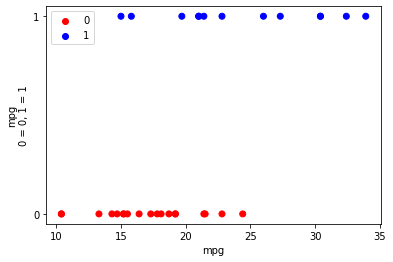

In [5]:
plot_binary(mtcars, 'mpg', 'am')
plt.legend();

We need our machinery for calculating the inverse logit transformation,
converting from the log-odds-ratio straight line prediction to the sigmoid
prediction.

In [6]:
def inv_logit(y):
    """ Reverse logit transformation
    """
    odds_ratios = np.exp(y)  # Reverse the log operation.
    return odds_ratios / (odds_ratios + 1)  # Reverse odds ratios operation.


def params2pps(intercept, slope, x):
    """ Calculate predicted probabilities of 1 for each observation.
    """
    # Predicted log odds of being in class 1.
    predicted_log_odds = intercept + slope * x
    return inv_logit(predicted_log_odds)

This is our simple root mean square cost function comparing the sigmoid p predictions to the 0 / 1 labels

In [7]:
def ss_logit(c_s, x_values, y_values):
    # Unpack intercept and slope into values.
    intercept, slope = c_s
    # Predicted p values on sigmoid
    pps = params2pps(intercept, slope, x_values)
    # Prediction errors.
    sigmoid_error = y_values - pps
    # Sum of squared error
    return np.sum(sigmoid_error ** 2)

We run minimize using some (it turns out) close-enough initial values for the
log-odds intercept and slope:

In [8]:
# Guessed log-odds intercept slope of -5, 0.5
mr_ss_ok = minimize(ss_logit, [-5, 0.5], args=(mpg, am_dummy))
mr_ss_ok

      fun: 4.903124915254889
 hess_inv: array([[19.62332134, -0.92499574],
       [-0.92499574,  0.0447687 ]])
      jac: array([-5.96046448e-08, -9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 120
      nit: 10
     njev: 40
   status: 0
  success: True
        x: array([-6.16442208,  0.28186367])

The prediction sigmoid looks reasonable:

In [9]:
inter_ok, slope_ok = mr_ss_ok.x
predicted_ok = inv_logit(inter_ok + slope_ok * mpg)

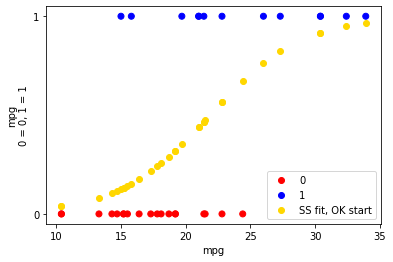

In [10]:
plot_binary(mtcars, 'mpg', 'am')
plt.scatter(mpg, predicted_ok, c='gold', label='SS fit, OK start')
plt.legend();

But - if we start with a not-so-close initial guess for the intercept and slope, `minimize` gets terribly lost:

In [11]:
# Guessed log-odds intercept slope of 1, 1
mr_ss_not_ok = minimize(ss_logit, [1, 1], args=(mpg, am_dummy))
mr_ss_not_ok

      fun: 12.99999999997786
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 0., -0.])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 1
     njev: 8
   status: 0
  success: True
        x: array([ 0.74090123, -1.74592614])

The prediction sigmoid fails completely:

In [12]:
inter_not_ok, slope_not_ok = mr_ss_not_ok.x
predicted_not_ok = inv_logit(inter_not_ok + slope_not_ok * mpg)

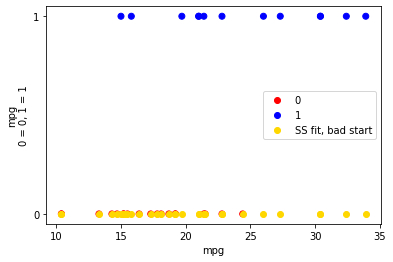

In [13]:
plot_binary(mtcars, 'mpg', 'am')
plt.scatter(mpg, predicted_not_ok, c='gold', label='SS fit, bad start')
plt.legend();

Can we do better with the maximum likelihood estimate (MLE) cost function?

In [14]:
def logit_reg_cost(intercept_and_slope, x, y):
    """ Cost function for maximum likelihood
    """
    intercept, slope = intercept_and_slope
    pp1 = params2pps(intercept, slope, x)
    p_of_y = y * pp1 + (1 - y) * (1 - pp1)
    log_likelihood = np.sum(np.log(p_of_y))
    return -log_likelihood

Here we pass some absolutely terrible initial guesses for the intercept and slope:

In [15]:
mr_LL = minimize(logit_reg_cost, [10, -5], args=(mpg, am_dummy))
mr_LL

      fun: 14.83758382412069
 hess_inv: array([[ 5.55735781, -0.2668813 ],
       [-0.2668813 ,  0.01334137]])
      jac: array([-2.38418579e-07, -4.64916229e-06])
  message: 'Optimization terminated successfully.'
     nfev: 57
      nit: 13
     njev: 19
   status: 0
  success: True
        x: array([-6.60352182,  0.30702795])

The fit is still reasonable:

In [16]:
inter_LL, slope_LL = mr_LL.x
predicted_LL = inv_logit(inter_LL + slope_LL * mpg)

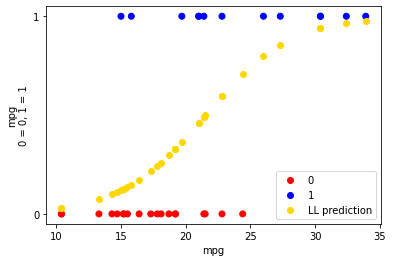

In [17]:
plot_binary(mtcars, 'mpg', 'am')
plt.scatter(mpg, predicted_LL, c='gold', label='LL prediction')
plt.legend();

As we have seen before, the MLE fit above is the same algorithm that
Statmodels and other packages use.

In [18]:
import statsmodels.formula.api as smf

In [19]:
model = smf.logit('am ~ mpg', data=mtcars)
fit = model.fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.463674
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     am   No. Observations:                   32
Model:                          Logit   Df Residuals:                       30
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 Apr 2021   Pseudo R-squ.:                  0.3135
Time:                        12:09:26   Log-Likelihood:                -14.838
converged:                       True   LL-Null:                       -21.615
Covariance Type:            nonrobust   LLR p-value:                 0.0002317
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.6035      2.351     -2.808      0.005     -11.212      -1.995
mpg            0.3070      0.115      2.673      0.008       0.082       0.532
==============================================================================
"""

Notice that the intercept and slope coefficients are the same as the ones we
found with the MLE cost function and minimize.